# Value at Risk Analysis

Complete VaR implementation with multiple methods and backtesting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

from src.risk_metrics import (
    historical_var, parametric_var, monte_carlo_var,
    expected_shortfall, rolling_var, var_backtest
)
from src.data_loader import load_csv

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
df = load_csv('../data/coffee_futures.csv')
returns = df['returns'].dropna().values

print(f"Total observations: {len(returns)}")
print(f"Mean daily return: {returns.mean():.4f}")
print(f"Daily volatility: {returns.std():.4f}")

Total observations: 1515
Mean daily return: 0.0010
Daily volatility: 0.0230


## 2. VaR Calculations

In [3]:
# portfolio setup
portfolio_value = 10_000_000  # $10M portfolio
confidence = 0.95
holding_period = 1  # days

# calculate VaR using all three methods
hist_var = historical_var(returns, confidence, holding_period)
param_var = parametric_var(returns, confidence, holding_period)
mc_var = monte_carlo_var(returns, 50000, confidence, holding_period)
es = expected_shortfall(returns, confidence)

print("=" * 60)
print(f"VALUE AT RISK - {confidence:.0%} Confidence, {holding_period}-Day")
print("=" * 60)
print(f"Portfolio Value: ${portfolio_value:,.0f}\n")

print(f"{'Method':<20} {'VaR %':>10} {'VaR $':>15}")
print("-" * 45)
print(f"{'Historical':<20} {hist_var:>10.2%} ${hist_var * portfolio_value:>14,.0f}")
print(f"{'Parametric':<20} {param_var:>10.2%} ${param_var * portfolio_value:>14,.0f}")
print(f"{'Monte Carlo':<20} {mc_var:>10.2%} ${mc_var * portfolio_value:>14,.0f}")
print("-" * 45)
print(f"{'Expected Shortfall':<20} {es:>10.2%} ${es * portfolio_value:>14,.0f}")

VALUE AT RISK - 95% Confidence, 1-Day
Portfolio Value: $10,000,000

Method                    VaR %           VaR $
---------------------------------------------
Historical                3.55% $       355,115
Parametric                3.69% $       368,575
Monte Carlo               3.67% $       366,785
---------------------------------------------
Expected Shortfall        4.70% $       470,043


In [4]:
# compare at different confidence levels
conf_levels = [0.90, 0.95, 0.99]

print("\nVaR at Different Confidence Levels:")
print("=" * 50)
print(f"{'Confidence':<12} {'Historical':>12} {'Parametric':>12} {'MC':>12}")
print("-" * 50)

for conf in conf_levels:
    h = historical_var(returns, conf) * 100
    p = parametric_var(returns, conf) * 100
    m = monte_carlo_var(returns, 20000, conf) * 100
    print(f"{conf:.0%}          {h:>11.2f}% {p:>11.2f}% {m:>11.2f}%")


VaR at Different Confidence Levels:
Confidence     Historical   Parametric           MC
--------------------------------------------------
90%                 2.64%        2.85%        2.83%
95%                 3.55%        3.69%        3.64%
99%                 5.30%        5.25%        5.34%


## 3. VaR Visualization

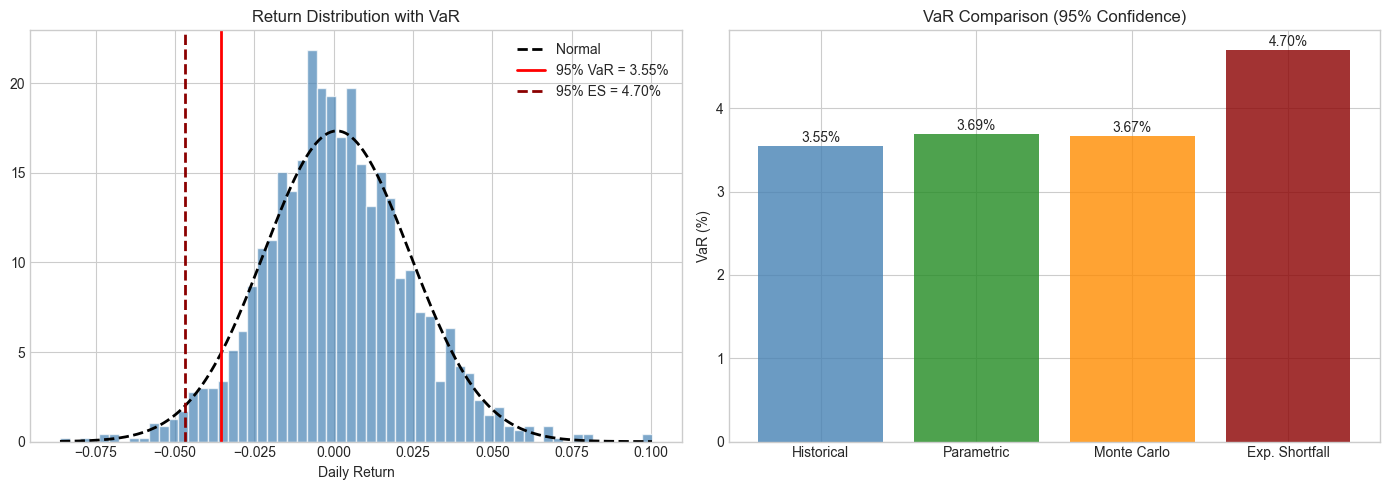

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# return distribution with VaR
ax = axes[0]
ax.hist(returns, bins=60, density=True, alpha=0.7, color='steelblue', edgecolor='white')

# overlay normal
x = np.linspace(returns.min(), returns.max(), 200)
ax.plot(x, stats.norm.pdf(x, returns.mean(), returns.std()), 'k--', linewidth=2, label='Normal')

# VaR lines
ax.axvline(-hist_var, color='red', linewidth=2, label=f'95% VaR = {hist_var:.2%}')
ax.axvline(-es, color='darkred', linewidth=2, linestyle='--', label=f'95% ES = {es:.2%}')

ax.set_title('Return Distribution with VaR', fontsize=12)
ax.set_xlabel('Daily Return')
ax.legend()

# method comparison
ax = axes[1]
methods = ['Historical', 'Parametric', 'Monte Carlo', 'Exp. Shortfall']
values = [hist_var, param_var, mc_var, es]
colors = ['steelblue', 'forestgreen', 'darkorange', 'darkred']

bars = ax.bar(methods, [v * 100 for v in values], color=colors, alpha=0.8)
ax.set_title('VaR Comparison (95% Confidence)', fontsize=12)
ax.set_ylabel('VaR (%)')

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{val:.2%}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/var_comparison.png', dpi=150)
plt.show()

## 4. Rolling VaR

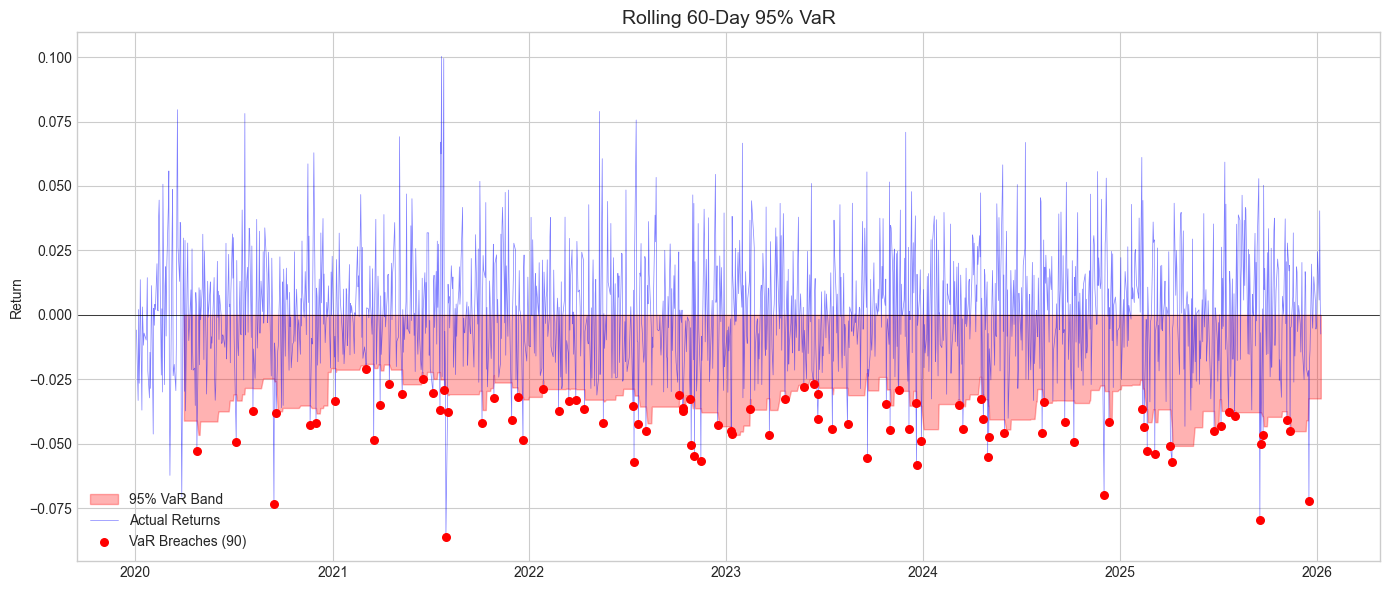


VaR Breaches: 90 out of 1455 days
Breach Rate: 6.19% (Expected: 5%)


In [6]:
# compute rolling VaR
window = 60  # 60 trading days
roll_var = rolling_var(returns, window, 0.95)

# create aligned dataframe
df_var = pd.DataFrame({
    'returns': returns,
    'var_95': roll_var
}, index=df.index[1:len(returns)+1])

fig, ax = plt.subplots(figsize=(14, 6))

ax.fill_between(df_var.index, 0, -df_var['var_95'], alpha=0.3, color='red', label='95% VaR Band')
ax.plot(df_var.index, df_var['returns'], 'b-', alpha=0.5, linewidth=0.5, label='Actual Returns')

# highlight breaches
breaches = df_var[df_var['returns'] < -df_var['var_95']]
ax.scatter(breaches.index, breaches['returns'], color='red', s=30, zorder=5, label=f'VaR Breaches ({len(breaches)})')

ax.axhline(0, color='black', linewidth=0.5)
ax.set_title(f'Rolling {window}-Day 95% VaR', fontsize=14)
ax.set_ylabel('Return')
ax.legend(loc='lower left')

plt.tight_layout()
plt.savefig('../outputs/rolling_var.png', dpi=150)
plt.show()

print(f"\nVaR Breaches: {len(breaches)} out of {len(df_var.dropna())} days")
print(f"Breach Rate: {len(breaches)/len(df_var.dropna())*100:.2f}% (Expected: 5%)")

## 5. VaR Backtesting

In [7]:
# backtest the VaR model
backtest = var_backtest(returns, roll_var, 0.95)

print("=" * 50)
print("VAR BACKTEST RESULTS")
print("=" * 50)
print(f"Exceptions (breaches): {backtest['exceptions']}")
print(f"Total days tested: {backtest['total_days']}")
print(f"Exception rate: {backtest['exception_rate']:.2%}")
print(f"Expected rate: {backtest['expected_rate']:.2%}")
print(f"\nTraffic Light Status: {backtest['status']}")

if backtest['status'] == 'GREEN':
    print("Model is performing well.")
elif backtest['status'] == 'YELLOW':
    print("Model needs monitoring - slightly more exceptions than expected.")
else:
    print("Model underestimating risk - review required.")

VAR BACKTEST RESULTS
Exceptions (breaches): 90
Total days tested: 1455
Exception rate: 6.19%
Expected rate: 5.00%

Traffic Light Status: GREEN
Model is performing well.


In [8]:
# Kupiec test for VaR validity
def kupiec_test(exceptions, n, alpha):
    """Kupiec's proportion of failures test."""
    p = 1 - alpha  # expected failure rate
    p_hat = exceptions / n  # actual failure rate
    
    if p_hat == 0:
        p_hat = 1e-10
    if p_hat == 1:
        p_hat = 1 - 1e-10
    
    # likelihood ratio
    lr = -2 * (np.log((1-p)**(n-exceptions) * p**exceptions) - 
               np.log((1-p_hat)**(n-exceptions) * p_hat**exceptions))
    
    # chi-squared test (1 dof)
    p_value = 1 - stats.chi2.cdf(lr, 1)
    
    return lr, p_value

lr, p_val = kupiec_test(backtest['exceptions'], backtest['total_days'], 0.95)

print("\nKupiec Test:")
print(f"Likelihood Ratio: {lr:.4f}")
print(f"P-value: {p_val:.4f}")
print(f"Result: {'PASS' if p_val > 0.05 else 'FAIL'} at 5% significance")


Kupiec Test:
Likelihood Ratio: 4.0167
P-value: 0.0451
Result: FAIL at 5% significance


## 6. Multi-Period VaR

In [9]:
# VaR for different holding periods
periods = [1, 5, 10, 21, 63, 252]
period_names = ['1 Day', '1 Week', '2 Weeks', '1 Month', '1 Quarter', '1 Year']

print("VaR by Holding Period (95% Confidence):")
print("=" * 50)
print(f"{'Period':<15} {'VaR %':>10} {'VaR $':>15}")
print("-" * 50)

var_by_period = []
for period, name in zip(periods, period_names):
    v = parametric_var(returns, 0.95, period)
    var_by_period.append(v)
    print(f"{name:<15} {v:>10.2%} ${v * portfolio_value:>14,.0f}")

VaR by Holding Period (95% Confidence):
Period               VaR %           VaR $
--------------------------------------------------
1 Day                3.69% $       368,575
1 Week               7.97% $       797,238
2 Weeks             10.99% $     1,098,937
1 Month             15.29% $     1,529,116
1 Quarter           23.89% $     2,389,155
1 Year              35.51% $     3,551,049


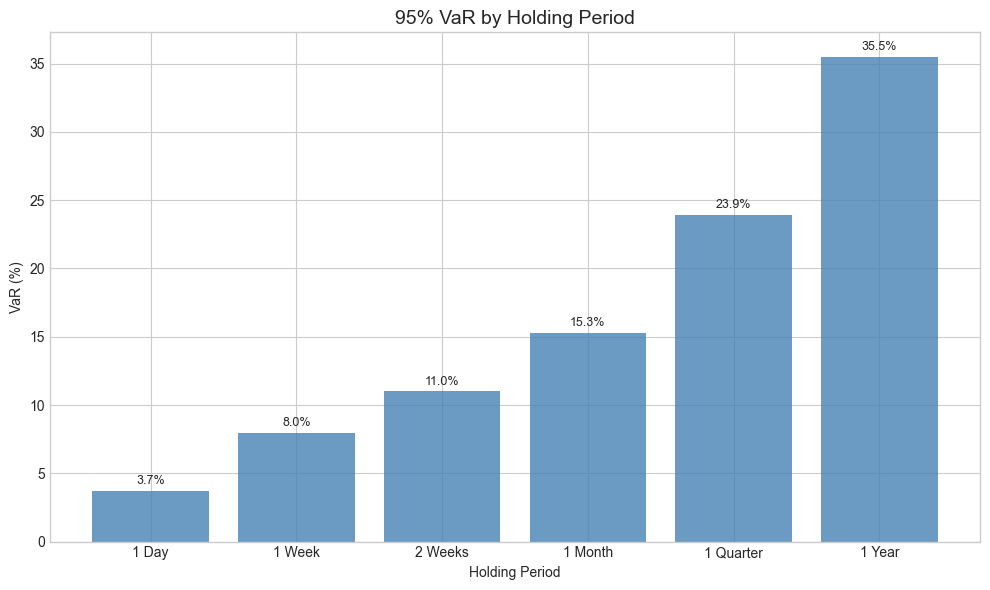

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(period_names, [v * 100 for v in var_by_period], color='steelblue', alpha=0.8)
ax.set_title('95% VaR by Holding Period', fontsize=14)
ax.set_ylabel('VaR (%)')
ax.set_xlabel('Holding Period')

for i, v in enumerate(var_by_period):
    ax.text(i, v * 100 + 0.5, f'{v:.1%}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/var_by_period.png', dpi=150)
plt.show()

## 7. Monte Carlo Details

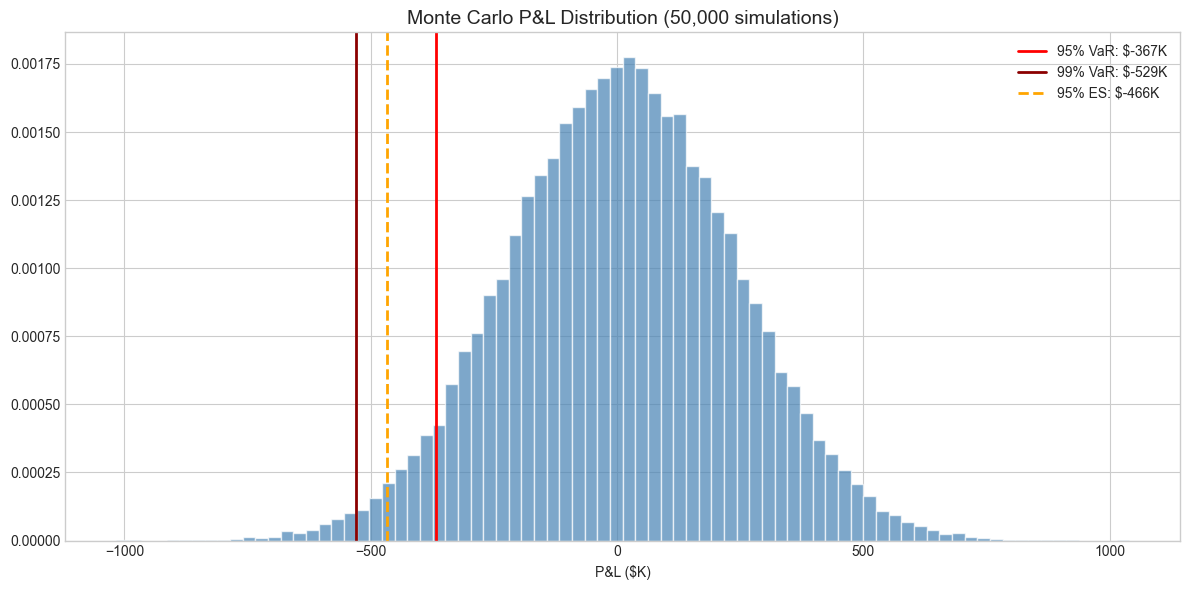


Monte Carlo Results (50,000 simulations):
Mean P&L: $9,643
Std P&L: $230,036
95% VaR: $366,785
99% VaR: $529,162
95% ES: $466,171


In [11]:
# detailed Monte Carlo simulation
n_sims = 50000
mu = returns.mean()
sigma = returns.std()

np.random.seed(42)
simulated_returns = np.random.normal(mu, sigma, n_sims)
simulated_pnl = simulated_returns * portfolio_value

# calculate VaR and ES from simulations
mc_var_95 = np.percentile(simulated_pnl, 5)
mc_var_99 = np.percentile(simulated_pnl, 1)
mc_es_95 = simulated_pnl[simulated_pnl < mc_var_95].mean()

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(simulated_pnl / 1000, bins=80, density=True, alpha=0.7, color='steelblue', edgecolor='white')
ax.axvline(mc_var_95 / 1000, color='red', linewidth=2, label=f'95% VaR: ${mc_var_95/1000:,.0f}K')
ax.axvline(mc_var_99 / 1000, color='darkred', linewidth=2, label=f'99% VaR: ${mc_var_99/1000:,.0f}K')
ax.axvline(mc_es_95 / 1000, color='orange', linewidth=2, linestyle='--', label=f'95% ES: ${mc_es_95/1000:,.0f}K')

ax.set_title(f'Monte Carlo P&L Distribution ({n_sims:,} simulations)', fontsize=14)
ax.set_xlabel('P&L ($K)')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/monte_carlo_pnl.png', dpi=150)
plt.show()

print(f"\nMonte Carlo Results ({n_sims:,} simulations):")
print(f"Mean P&L: ${simulated_pnl.mean():,.0f}")
print(f"Std P&L: ${simulated_pnl.std():,.0f}")
print(f"95% VaR: ${abs(mc_var_95):,.0f}")
print(f"99% VaR: ${abs(mc_var_99):,.0f}")
print(f"95% ES: ${abs(mc_es_95):,.0f}")

## 8. Summary Report

In [12]:
print("\n" + "=" * 70)
print("VaR ANALYSIS SUMMARY REPORT")
print("=" * 70)

report = f"""
Portfolio: Coffee Futures
Value: ${portfolio_value:,.0f}
Data Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}

1-DAY 95% VaR ESTIMATES:
------------------------
Historical Simulation: ${hist_var * portfolio_value:>15,.0f} ({hist_var:.2%})
Parametric (Normal):   ${param_var * portfolio_value:>15,.0f} ({param_var:.2%})
Monte Carlo (50K):     ${mc_var * portfolio_value:>15,.0f} ({mc_var:.2%})

EXPECTED SHORTFALL:
-------------------
95% ES:                ${es * portfolio_value:>15,.0f} ({es:.2%})

BACKTEST RESULTS:
-----------------
Exceptions: {backtest['exceptions']} / {backtest['total_days']} days
Exception Rate: {backtest['exception_rate']:.2%} (Expected: 5%)
Status: {backtest['status']}
Kupiec Test: {'PASS' if p_val > 0.05 else 'FAIL'} (p={p_val:.4f})

KEY INSIGHTS:
-------------
- On 95% of days, expect to lose no more than ${hist_var * portfolio_value:,.0f}
- When losses exceed VaR, average loss is ${es * portfolio_value:,.0f} (ES)
- VaR model is {'accurate' if backtest['status'] == 'GREEN' else 'needs review'}
"""

print(report)


VaR ANALYSIS SUMMARY REPORT

Portfolio: Coffee Futures
Value: $10,000,000
Data Period: 2020-01-02 to 2026-01-08

1-DAY 95% VaR ESTIMATES:
------------------------
Historical Simulation: $        355,115 (3.55%)
Parametric (Normal):   $        368,575 (3.69%)
Monte Carlo (50K):     $        366,785 (3.67%)

EXPECTED SHORTFALL:
-------------------
95% ES:                $        470,043 (4.70%)

BACKTEST RESULTS:
-----------------
Exceptions: 90 / 1455 days
Exception Rate: 6.19% (Expected: 5%)
Status: GREEN
Kupiec Test: FAIL (p=0.0451)

KEY INSIGHTS:
-------------
- On 95% of days, expect to lose no more than $355,115
- When losses exceed VaR, average loss is $470,043 (ES)
- VaR model is accurate

